In [1]:
import numpy as np  
import pandas as pd
from scipy.stats import norm
import math
import matplotlib.pyplot as plt 


In [2]:
def d1(underlying, strike, dte, vol, interest):
    dte = dte/365
    return (1/(vol*np.sqrt(dte)))*(np.log(underlying/strike)+(interest+(vol**2)/2)*dte)

In [3]:
def d2(underlying, strike, dte, vol, interest):
    return d1(underlying, strike, dte, vol, interest)-(vol*np.sqrt(dte/365))

In [4]:
def nd1(underlying, strike, dte, vol, interest):
    return np.exp(-(d1(underlying, strike, dte, vol, interest)**2)/2)/np.sqrt(2*math.pi)

In [5]:
def price_call(underlying, strike, dte, vol, interest):
    return (norm.cdf(d1(underlying, strike, dte, vol, interest))*underlying)-(norm.cdf(d2(underlying, strike, dte, vol, interest))*strike*np.exp(-interest*(dte/365)))

In [6]:
def price_put(underlying, strike, dte, vol, interest):
    return (norm.cdf(-d2(underlying, strike, dte, vol, interest))*strike*np.exp(-interest*(dte/365)))-(norm.cdf(-d1(underlying, strike, dte, vol, interest))*underlying)

In [7]:
def strike_put(underlying, delta, dte, vol, interest):
    dte = dte/365
    return underlying*np.exp(norm.ppf(-1*delta)*vol*np.sqrt(dte)+(.5*vol**2*dte))

In [8]:
def strike_call(underlying, delta, dte, vol, interest):
    dte = dte/365
    return underlying*np.exp(-norm.ppf(delta)*vol*np.sqrt(dte)+(.5*vol**2*dte))

In [9]:
def spy_price_sim(s0,days,members,vol,vol_offset):
    mu = 0.00037335
    stdev = (vol-vol_offset)*np.sqrt(1/365)
    var= stdev**2
    drift = mu - (0.5*var)
    #stdev = np.sqrt(var)

    daily_returns = np.exp(drift + stdev * norm.ppf(np.random.rand(days, members)))
    price_list = np.zeros_like(daily_returns)
    price_list[0] = s0
    for t in range(1, days):
        price_list[t] = price_list[t - 1] * daily_returns[t]
    plt.figure(figsize=(10,6))
    plt.axhline(y=s0, color='k', linestyle='-')
    plt.plot(price_list);
    return price_list

In [10]:
def put_simulate(prices,put_delta,vol,interest):
    dte = prices.shape[0]
    s0 = prices[0,0]
    put_k = strike_put(s0,put_delta,dte,vol,interest)
    put_list = np.zeros_like(prices)
    for t in range(0,dte):
        put_list[t] = price_put(prices[t],put_k,dte-t,vol,interest)
    plt.plot(put_list)
    return put_list,put_list[0,0]

In [11]:
dte = 45
s0 = 100
put_delta = -.30
call_delta = 0.30
vol = 0.25
vol_offset = 0.03
interest = 0.03
n = 5000

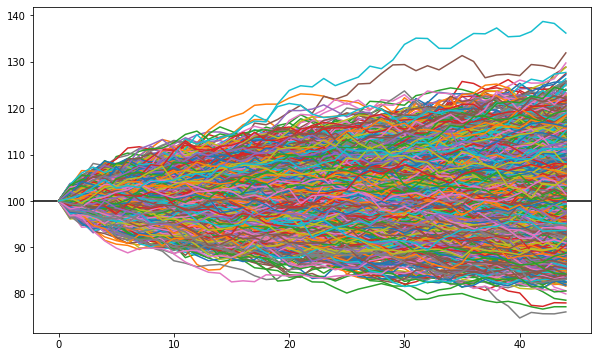

In [12]:
x = spy_price_sim(s0,dte,n,vol,vol_offset)

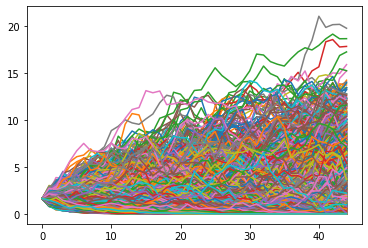

In [13]:
puts,put0 = put_simulate(x,put_delta, vol, interest)

In [14]:
PL = put0 - puts

In [15]:
num_winners_expiry = np.sum(PL[-1]>=0.0)
avg_PL_expiry = np.mean(PL[-1])
max_loss_expiry = np.min(PL[-1])

In [16]:
num_winners_21dte = np.sum(PL[24]>=0.0)
avg_PL_21dte = np.mean(PL[24])
max_loss_21dte = np.min(PL[24])

In [17]:
PL_50percent_21days = PL[:26,:]
PL_50percent_21days[25,:] = 25
for row in range(n):
    i = 0
    for j in range(25):
        if (i < 1) and (PL_50percent_21days[j,row] >= (put0*0.5)):
            PL_50percent_21days[24,row]=PL_50percent_21days[j,row]
            PL_50percent_21days[25,row]=j
            i = 1   

In [18]:
num_winners_50percent_21dte = np.sum(PL_50percent_21days[24]>=0.0)
avg_PL_50percent_21dte = np.mean(PL_50percent_21days[24])
max_loss_50percent_21dte = np.min(PL_50percent_21days[24])
avg_duration = np.mean(PL_50percent_21days[25])

In [19]:
print('Selling OTM puts at '+str(-100*put_delta)+' delta')
print('Win percent at expiration = '+str((num_winners_expiry/n)*100)+'%')
print('Averge P/L at expiration= $'+str(avg_PL_expiry*100))
print('Max loss at expiration = $'+str(max_loss_expiry*100))
print('Win percent at 21 DTE = '+str((num_winners_21dte/n)*100)+'%')
print('Averge P/L 21 DTE = $'+str(avg_PL_21dte*100))
print('Max loss at 21 DTE = $'+str(max_loss_21dte*100))
print('Win percent at 50% MP or 21 DTE = '+str((num_winners_50percent_21dte/n)*100)+'%')
print('Averge P/L at 50% MP or 21 DTE = $'+str(avg_PL_50percent_21dte*100))
print('Max loss at 50% MP or 21 DTE = $'+str(max_loss_50percent_21dte*100))
print('Average time in trade: '+str(avg_duration)+' days')

Selling OTM puts at 30.0 delta
Win percent at expiration = 83.34%
Averge P/L at expiration= $65.58314339322993
Max loss at expiration = $-1814.4200290506421
Win percent at 21 DTE = 73.6%
Averge P/L 21 DTE = $37.53046339704296
Max loss at 21 DTE = $-1280.9442799397675
Win percent at 50% MP or 21 DTE = 78.84%
Averge P/L at 50% MP or 21 DTE = $27.783795059512865
Max loss at 50% MP or 21 DTE = $-1280.9442799397675
Average time in trade: 14.738 days
